### 加载mnist数据集

In [1]:
from keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data() # 将下载好的mnist.npz方在 ~/.keras/datasets/ 目录下
print(x_train.shape,type(x_train))
print(y_train.shape,type(y_train))
print(x_test.shape,type(x_test))
print(y_test.shape,type(y_test))

D:\software\python\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>
(10000, 28, 28) <class 'numpy.ndarray'>
(10000,) <class 'numpy.ndarray'>


### 数据处理：规范化
`channels_last`对应的输入：(batch,height,width,channels)

`channels_first`对应的输入：(batch,channels,height,width)

默认`channels_last`，修改：~/.keras/keras.json

In [3]:
from keras import backend as K

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print(x_train.shape, type(x_train))
print(x_test.shape, type(x_test))

(60000, 28, 28, 1) <class 'numpy.ndarray'>
(10000, 28, 28, 1) <class 'numpy.ndarray'>


In [7]:
# 将数据转换为float32，为了进行归一化，不然/255得到全部是0
X_train = x_train.astype('float32')
X_test = x_test.astype('float32')
# 数据归一化
X_train /= 255
X_test /= 255

### 统计训练数据中个标签数量

In [8]:
import numpy as np
import matplotlib.pyplot as plt

label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


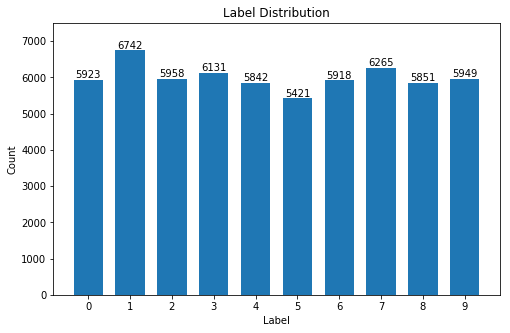

In [9]:
fig = plt.figure(figsize=(8, 5))
plt.bar(label, count, width=0.7, align='center')
plt.title("Label Distribution")
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(label)
plt.ylim(0, 7500)

for a, b in zip(label, count):
    plt.text(a, b, '%d' % b, ha='center', va='bottom', fontsize=10)

plt.show()

###  对标签进行one-hot编码

In [10]:
from keras.utils import np_utils

n_classes = 10
Y_train = np_utils.to_categorical(y_train,n_classes)
Y_test = np_utils.to_categorical(y_test,n_classes)

print(Y_train.shape)

(60000, 10)


In [11]:
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 使用Keras sequential model 定义MNIST CNN网络

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
## Feature Extraction
# 第一层卷积，32个3*3的卷积核，激活函数使用relu
model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape))
# 第二层卷积，64个3*3的卷积核，激活函数使用relu
model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
# 最大池化层
model.add(MaxPooling2D(pool_size=(2,2)))
# Dropout 25% 的输入神经元
model.add(Dropout(0.25))
# 将Pooled feature map 摊平后输入全连接网络
model.add(Flatten())

## Classification
# 全连接层
model.add(Dense(128,activation='relu'))
# Dropout 50% 的输入神经元
model.add(Dropout(0.5))
# 使用softmax 激活函数做多分类，输出各数字的概率
model.add(Dense(10, activation='softmax'))

### 查看 MNIST CNN 模型网络结构

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [17]:
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())

[None, 26, 26, 32]
[None, 24, 24, 64]
[None, 12, 12, 64]
[None, 12, 12, 64]
[None, None]
[None, 128]
[None, 128]
[None, 10]


### 编译模型

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### 训练模型，并将指标保存到history中

In [21]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=5,verbose=2, validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 131s - loss: 0.2330 - acc: 0.9290 - val_loss: 0.0540 - val_acc: 0.9817
Epoch 2/5
 - 146s - loss: 0.0853 - acc: 0.9747 - val_loss: 0.0372 - val_acc: 0.9882
Epoch 3/5
 - 136s - loss: 0.0605 - acc: 0.9812 - val_loss: 0.0315 - val_acc: 0.9898
Epoch 4/5
 - 129s - loss: 0.0514 - acc: 0.9843 - val_loss: 0.0283 - val_acc: 0.9913
Epoch 5/5
 - 130s - loss: 0.0416 - acc: 0.9873 - val_loss: 0.0272 - val_acc: 0.9911


### 可视化指标

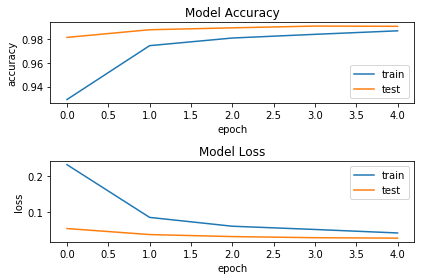

In [22]:
fig = plt.figure()
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.tight_layout()

plt.show()

### 保存模型

In [24]:
import os
import tensorflow.gfile as gfile

save_dir = '.\model'
if gfile.Exists(save_dir):
    gfile.DeleteRecursively(save_dir)
gfile.MakeDirs(save_dir)

model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir,model_name)
model.save(model_path)
print('Saved trained model at %s' % model_path)

Saved trained model at .\model\keras_mnist.h5


### 加载模型

In [25]:
from keras.models import load_model

mnist_model = load_model(model_path)

### 统计模型在测试集上的分类结果

In [26]:
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {}%".format(loss_and_metrics[1]*100))

predicted_classes = mnist_model.predict_classes(X_test)
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.027159390095694836
Test Accuracy: 99.11%
Classified correctly count: 9911
Classified incorrectly count: 89
